# Visualize patched sphere simulations

In [2]:
%cd ..

/home/gridsan/dkannan/git-remotes/protein_mobility


In [3]:
import nglutils as ngu
import nglview as nv

import os
import sys
from pathlib import Path
import numpy as np
import scipy as sp
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt

import mdtraj
import polychrom
from polychrom.hdf5_format import list_URIs, load_URI, load_hdf5_file

In [4]:
from analysis_scripts.multimerization import *

In [5]:
%matplotlib inline

In [6]:
slide_width = 11.5
half_slide_width = 5.67
aspect_ratio = 5/7
pres_params = {'axes.edgecolor': 'black',
                  'axes.facecolor':'white',
                  'axes.grid': False,
                  'axes.linewidth': 0.5,
                  'backend': 'ps',
                  'savefig.format': 'pdf',
                  'axes.titlesize': 20,
                  'axes.labelsize': 18,
                  'legend.fontsize': 18,
                  'xtick.labelsize': 16,
                  'ytick.labelsize': 16,
                  'text.usetex': False,
                  'figure.figsize': [half_slide_width, half_slide_width * aspect_ratio],
                  'font.family': 'sans-serif',
                   'font.size': 14,
                  #'mathtext.fontset': 'cm',
                  'xtick.bottom':True,
                  'xtick.top': False,
                  'xtick.direction': 'out',
                  'xtick.major.pad': 3,
                  'xtick.major.size': 3,
                  'xtick.minor.bottom': False,
                  'xtick.major.width': 0.2,

                  'ytick.left':True,
                  'ytick.right':False,
                  'ytick.direction':'out',
                  'ytick.major.pad': 3,
                  'ytick.major.size': 3,
                  'ytick.major.width': 0.2,
                  'ytick.minor.right':False,
                  'lines.linewidth':2}
plt.rcParams.update(pres_params)

In [7]:
def extract_trajectory(simdir, wrap=False, start=0, end=-1, every_other=10):
    """Load conformations from a simulation trajectory stored in the hdf5 files in simdir.
    
    Parameters
    ----------
    simdir : str or Path
        path to simulation directory containing .h5 files
    start : int
        which time block to start loading conformations from
    end : int
        which time block to stop loading conformations from
    every_other : int
        skip every_other time steps when loading conformations
        
    Returns
    -------
    X : array_like (num_t, N, 3)
        x, y, z positions of all monomers over time
    
    """
    X = []
    data = list_URIs(simdir)
    print(len(data))
    #check if PBCbox was used
    initArgs = load_hdf5_file(Path(simdir)/"initArgs_0.h5")
    PBCbox = np.array(initArgs['PBCbox'])
    if PBCbox.any():
        boxsize = PBCbox
    if start == 0:
        starting_pos = load_hdf5_file(Path(simdir)/"starting_conformation_1.h5")['pos']
        X.append(starting_pos)
    for conformation in data[start:end:every_other]:
        pos = load_URI(conformation)['pos']
        if PBCbox.any() and wrap:
            mults = np.floor(pos / boxsize[None, :])
            pos = pos - mults * boxsize[None, :]
            assert pos.min() >= 0
        X.append(pos)
    X = np.array(X)
    return X, boxsize

def patched_particle_geom(f, R=1):
    """ Distribute f residues on a sphere with equal angles."""
    
    #first position is center particle
    positions = [[0., 0., 0.]]
    theta = np.pi/2
    for i in range(min(f, 5)):
        #for valency less than 5, just distribute points on a circle in the x-y plane
        phi = 2 * np.pi * i / f
        x = R * np.sin(theta) * np.cos(phi)
        y = R * np.sin(theta) * np.sin(phi)
        z = R * np.cos(theta)
        positions.append([x, y, z])
    
    if f >=5:
        #octahedron -> put 5th particle perpendicular to plain of 4 points
        print("Have not implemented yet")
    return np.array(positions)

#make a topology for this f+1-atom chain
def mdtop_for_patched_particles(N, nchains, f, atom_names="XXX"):
    """
    Generate an mdtraj.Topology object for a single polymer of length N.

    Parameters
    ----------
    N : int
        total number of particles
    nchains : int
        number of tetramers
    f : int
        valency, i.e. number of patches
    atom_names : string (up to 3 characters) or list of such
        names for the atoms. This can be useful for labelling different types
        of monomers, such as compartments. If given as list, should have length
        N.

    Notes
    -----
        - use iron as element to prevent NGLView from calculating bonds
    """

    # Check that atom names are good
    if isinstance(atom_names, str):
        atom_names = [atom_names[:3] for _ in range(N)]
    elif not isinstance(atom_names, list) or not len(atom_names) == N:
        print("WARNING: atom_names should be a list of length N = {}. Using default." % N)
        atom_names = ["XXX" for _ in range(N)]

    # Generate topology
    top = mdtraj.Topology()
    resi = 0
    for i in range(nchains):
        ch = top.add_chain()
        res = top.add_residue("{0:03d}".format(resi // 10000), ch)
        first_atom = top.add_atom(atom_names[resi], mdtraj.element.iron, res)
        resi += 1
        for k in range(f):
            res = top.add_residue("{0:03d}".format(resi // 10000), ch)
            cur_atom = top.add_atom(atom_names[resi], mdtraj.element.iron, res)
            top.add_bond(first_atom, cur_atom)
            resi += 1
    return top


In [8]:
DATADIR = Path('/home/gridsan/dkannan/git-remotes/protein_mobility/results')

In [9]:
def make_animation(f, E0, N=1000, vol_fraction=0.3, r=0.5, rep_r=1.05, Erep=60.0, dt=10, wrap=True, start=0, end=1000, mixed=False):
    if mixed:
        Y, boxsize = extract_trajectory(DATADIR/f"N{N}_f0_2_E0{E0}_v{vol_fraction}_r{r}_rep{rep_r}_Erep{Erep}_dt{dt}", 
                                wrap=wrap, start=start, end=end, every_other=1)
    else:
        Y, boxsize = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}_r{r}_rep{rep_r}_Erep{Erep}_dt{dt}", 
                                wrap=wrap, start=start, end=end, every_other=1)
    print(Y.shape)
    X = Y
    print(X.shape)
    N = int(Y.shape[1]/(f+1))
    print(N)
    print(X.shape)
    atom_names = (['B'] + ['A']*f) * N
    top = mdtop_for_patched_particles((f+1)*N, N, f, atom_names=atom_names)
    view = ngu.xyz2nglview(X, top=top)
    view.add_representation('ball+stick', selection='.A',
                                                colorScheme='uniform',
                                                colorValue=0xff4242, radius=0.15)
    view.add_representation('ball+stick', selection='.B', colorScheme='uniform',
                            colorValue=0xA2A2A2, radius=0.35)
    view.add_unitcell()
    return view

def make_snapshot(Y, f):
    X = Y
    N = int(Y.shape[0]/(f+1))
    print(N)
    print(X.shape)
    atom_names = (['B'] + ['A']*f) * N
    top = mdtop_for_patched_particles((f+1)*N, N, f, atom_names=atom_names)
    view = ngu.xyz2nglview(X, top=top)
    view.add_representation('ball+stick', selection='.A',
                                                colorScheme='uniform',
                                                colorValue=0xff4242, radius=0.15)
    view.add_representation('ball+stick', selection='.B', colorScheme='uniform',
                            colorValue=0xA2A2A2, radius=0.35)
    view.add_unitcell()
    return view

In [17]:
make_animation(2, 30.0, N=1000, r=0.2, rep_r=1.2, Erep=50.0, vol_fraction=0.3, dt=5, wrap=False, start=20, end=1000, mixed=True)

13000
(980, 3000, 3)
(980, 3000, 3)
1000
(980, 3000, 3)


NGLWidget(max_frame=979)

In [42]:
starting_pos = load_hdf5_file(DATADIR/'test_energy_minimization/starting_conformation_0.h5')
energy_min = load_hdf5_file(DATADIR/'test_energy_minimization/energy_minimization_0.h5')
energy_min

{'pos': array([[ 0.6026108 , -1.0213804 , -0.54534197],
        [ 1.0192792 , -0.79825145, -0.3719754 ],
        [ 0.5270705 , -0.97784275,  0.5700945 ],
        ...,
        [ 3.2805989 , -0.7782918 , -0.3838902 ],
        [ 1.7152783 , -0.8403738 , -0.5315819 ],
        [ 2.1620872 , -0.79346275, -0.35204005]], dtype=float32),
 'block': 0,
 'time': 0}

In [44]:
make_snapshot(starting_pos['pos'], 1)

1000
(2000, 3)


NGLWidget()

In [45]:
make_snapshot(energy_min['pos'], 1)

1000
(2000, 3)


NGLWidget()

## Test DBscan for clustering

In [9]:
import sklearn

In [10]:
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.sparse import csr_matrix, coo_matrix
from matplotlib import pyplot as plt

def particles_from_mols(mol_ids, f):
    """ Return particle IDs (including patches) from list of molecule IDs"""
    particles = []
    for mol in mol_ids:
        particles += [mol + i for i in range(f + 1)]
    return particles

In [11]:
#def cluster_snapshot(f, E0, snapshot_ind, N=1000, vol_fraction=0.3):
f = 2
N = 1000
E0 = 30.0
vol_fraction = 0.3
Y, boxsize = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}_r0.2_rep1.2_Erep50.0_dt5", wrap=False, 
                           start=1000, every_other=1)
Ywrapped, boxsize = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}_r0.2_rep1.2_Erep50.0_dt5", wrap=True, 
                           start=1000, every_other=1)
#indices of larger spheres
print(Y.shape)
print(boxsize)
molecule_inds = np.arange(0, (f+1)*N, f+1)
X = Y[-1, molecule_inds, :]
print(X.shape)

10000
10000
(8999, 3000, 3)
[13.84597776 13.84597776 13.84597776]
(1000, 3)


In [42]:
X[:,0].max()

97.6

In [12]:
def pdist_PBC(X, boxsize):
    """ Pairwise distances with periodic boundary conditions. """
    N = X.shape[0]
    dim = X.shape[1]
    dist_nd_sq = np.zeros(N * (N - 1) // 2)  # to match the result of pdist
    for d in range(dim):
        pos_1d = X[:, d][:, np.newaxis]  # shape (N, 1)
        dist_1d = pdist(pos_1d)  # shape (N * (N - 1) // 2, )
        dist_1d -= boxsize[d] * np.rint(dist_1d / boxsize[d])
        dist_nd_sq += dist_1d ** 2  # d^2 = dx^2 + dy^2 + dz^2
    dist_nd = np.sqrt(dist_nd_sq)
    return dist_nd

def cdist_PBC(X, Y, boxsize):
    cdist_nd_sq = np.zeros((X.shape[0], Y.shape[0]))
    dim = len(boxsize)
    for d in range(dim):
        xpos_1d = X[:, d][:, np.newaxis]  # shape (N, 1)
        ypos_1d = Y[:, d][:, np.newaxis]  # shape (M, 1)
        dist_1d = cdist(xpos_1d, ypos_1d)  # shape (N, M)
        dist_1d -= boxsize[d] * np.rint(dist_1d / boxsize[d])
        cdist_nd_sq += dist_1d ** 2  # d^2 = dx^2 + dy^2 + dz^2
    dist_nd = np.sqrt(cdist_nd_sq)
    return dist_nd


In [22]:
%%time
distances = pdist(X)
len(distances[distances <= 1.1])

CPU times: user 7.33 ms, sys: 0 ns, total: 7.33 ms
Wall time: 39.9 ms


248

In [68]:
len(distances[distances <= 1.1])

987

In [13]:
distances = pdist_PBC(X, boxsize)
print(len(distances))
cutoff = 1.4
dist_matrix = squareform(distances)
dist_graph = dist_matrix.copy()
dist_graph[dist_matrix > cutoff] = 0.0 #dist_graph is dense and symmetric
neighbors = dist_graph.sum(axis=1)
print(f'Fraction of particles that have at least 1 neighbor : {np.sum(neighbors > 0) / dist_graph.shape[0]}')
dist_graph_lower = dist_graph.copy()
#set the lower triangle to zero since its redundant
lower_triangle_indices = np.tril_indices(dist_graph_lower.shape[0], k=-1)
dist_graph_lower[lower_triangle_indices] = 0.0
print(np.sum(dist_graph_lower > 0)) #dist graph lower is dense and upper triangular
print(len(distances[distances <= cutoff]))
dist_graph_sparse = coo_matrix(dist_graph_lower)
print(dist_graph_sparse)



499500
Fraction of particles that have at least 1 neighbor : 1.0
1933
1933
  (0, 329)	1.1814397625964301
  (0, 479)	1.3240463637593374
  (0, 511)	1.1729452842399521
  (0, 512)	1.1584904343988498
  (0, 855)	0.05744573769609043
  (0, 896)	1.335723631282147
  (1, 207)	1.1337550109323893
  (1, 332)	1.1514337089081748
  (2, 45)	1.1814398998225595
  (2, 46)	1.1691871959564777
  (2, 47)	1.1712384840360408
  (2, 111)	0.09110430124786455
  (2, 518)	1.149738956180312
  (2, 558)	1.2676527098573158
  (2, 953)	1.328219867299579
  (3, 42)	1.1626261861262432
  (3, 109)	1.1918471352211253
  (3, 557)	1.3580754525415026
  (3, 847)	1.152779236766302
  (3, 850)	1.1590081713489728
  (4, 213)	1.1540155609716933
  (4, 677)	1.140657367571116
  (5, 70)	1.3241597792197228
  (5, 71)	1.2828480730410352
  (5, 156)	1.2853886341922403
  :	:
  (940, 970)	1.1590511935483538
  (942, 995)	0.10440305115893016
  (944, 949)	1.1400444969063421
  (945, 997)	1.355812967397688
  (945, 998)	1.38518183921834
  (947, 983)	1.17456

In [14]:
#prune edges in sparse graph where inter-patch distances are > 0.5

#copy a dense matrix here (dist_graph is dense and symmetric)
#for edge in sparse graph
for i, (r, c, d) in enumerate(zip(dist_graph_sparse.row, dist_graph_sparse.col, dist_graph_sparse.data)):
    node1_patches = np.array([Y[-1, r*(f+1) + k, :] for k in range(1, f+1)])
    node2_patches = np.array([Y[-1, c*(f+1) + k, :] for k in range(1, f+1)])
    inter_patch_distances = cdist_PBC(node1_patches, node2_patches, boxsize)
    if np.all(inter_patch_distances > 0.5):
        print(f"Deleted edge {i}: ({r}, {c}) with weight {d}")
        dist_graph[r, c] = 0.0
        dist_graph[c, r] = 0.0

#if you havent found a single patch-patch distances within interaction range, remove edge
#dist_graph[r, c] = 0.0
print(np.sum(dist_graph > 0) / 2)
neighbors = dist_graph.sum(axis=1)
print(f'Fraction of particles that have at least 1 neighbor after pruning : {np.sum(neighbors > 0) / dist_graph.shape[0]}')

Deleted edge 1: (0, 479) with weight 1.3240463637593374
Deleted edge 5: (0, 896) with weight 1.335723631282147
Deleted edge 13: (2, 558) with weight 1.2676527098573158
Deleted edge 14: (2, 953) with weight 1.328219867299579
Deleted edge 17: (3, 557) with weight 1.3580754525415026
Deleted edge 22: (5, 70) with weight 1.3241597792197228
Deleted edge 23: (5, 71) with weight 1.2828480730410352
Deleted edge 24: (5, 156) with weight 1.2853886341922403
Deleted edge 25: (5, 157) with weight 1.3350439320328615
Deleted edge 29: (6, 333) with weight 1.2993917269944586
Deleted edge 30: (6, 338) with weight 1.241581260778915
Deleted edge 31: (6, 340) with weight 1.30068328383239
Deleted edge 34: (7, 199) with weight 1.3406119338882896
Deleted edge 35: (7, 339) with weight 1.2453850086214822
Deleted edge 36: (7, 354) with weight 1.2984052844973173
Deleted edge 37: (7, 365) with weight 1.3590134498423634
Deleted edge 38: (7, 808) with weight 1.3207356923966345
Deleted edge 43: (9, 342) with weight 1.

In [26]:
r = 997
c = 999
node1_patches = np.array([Y[-1, r*(f+1) + k, :] for k in range(1, f+1)])
node2_patches = np.array([Y[-1, c*(f+1) + k, :] for k in range(1, f+1)])
inter_patch_distances = cdist_PBC(node1_patches, node2_patches, boxsize)
inter_patch_distances

array([[0.23579711]])

In [27]:
particles = particles_from_mols([r, c], f)
print(particles)
cluster_size = 2 #single edge
atom_names = (['B'] + ['A']*f) * cluster_size
top = mdtop_for_patched_particles((f+1)*cluster_size, cluster_size, f, atom_names=atom_names)
view = ngu.xyz2nglview(Y[-1, particles, :], top=top)
view.add_representation('ball+stick', selection='.A',
                                            colorScheme='uniform',
                                            colorValue=0xff4242, radius=0.15)
view.add_representation('ball+stick', selection='.B', colorScheme='uniform',
                        colorValue=0xA2A2A2, radius=0.3)
view

[997, 998, 999, 1000]


NGLWidget()

In [15]:
dist_graph_sparse = csr_matrix(dist_graph)
dist_graph_sparse = sklearn.neighbors.sort_graph_by_row_values(dist_graph_sparse)
#clustering based on adjacency matrix (should yield same result)
clustering = DBSCAN(eps=cutoff, min_samples=2, metric="precomputed").fit(dist_graph_sparse)
unique_values, counts = np.unique(clustering.labels_, return_counts=True)
if len(counts) > 1:
    print(f"Distance cutoff = {cutoff}, # clusters = {len(unique_values)-1}, max cluster size = {counts[1:].max()}")

Distance cutoff = 1.4, # clusters = 12, max cluster size = 293


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(


In [16]:
print(counts)
print('fraction in multimer: ' + f'{np.sum(counts[1:]) / 1000.0}')
multimers, number_observed = np.unique(counts[1:], return_counts=True)
cluster_histogram = np.zeros(1000)
print(multimers)
print(number_observed)
for m in range(len(multimers)):
    cluster_histogram[multimers[m] - 1] += number_observed[m] * multimers[m]
print(cluster_histogram[0:5])

[ 73 162 148  19  26  18 293  72  16  44  64  55  10]
fraction in multimer: 0.927
[ 10  16  18  19  26  44  55  64  72 148 162 293]
[1 1 1 1 1 1 1 1 1 1 1 1]
[0. 0. 0. 0. 0.]


In [17]:
for cluster in unique_values:
    mols_in_cluster = molecule_inds[clustering.labels_==cluster]
    particles = particles_from_mols(mols_in_cluster, 1)
    inter_cluster_distances = pdist(Y[-1, mols_in_cluster, :])
    if len(mols_in_cluster) >= 2:
        print(f"Cluster {cluster} with {len(mols_in_cluster)} molecules")

Cluster 0 with 73 molecules
Cluster 1 with 162 molecules
Cluster 2 with 148 molecules
Cluster 3 with 19 molecules
Cluster 4 with 26 molecules
Cluster 5 with 18 molecules
Cluster 6 with 293 molecules
Cluster 7 with 72 molecules
Cluster 8 with 16 molecules
Cluster 9 with 44 molecules
Cluster 10 with 64 molecules
Cluster 11 with 55 molecules
Cluster 12 with 10 molecules


In [18]:
mols_in_cluster = molecule_inds[clustering.labels_==1]
particles = particles_from_mols(mols_in_cluster, f)
print(mols_in_cluster)
protein_positions = Y[-1, mols_in_cluster, :]
patches_in_cluster = np.array([ind + 1 for ind in mols_in_cluster])
print(patches_in_cluster)
patch_positions = Y[-1, patches_in_cluster, :]
inter_patch_distances = pdist_PBC(protein_positions, boxsize)
print(inter_patch_distances)
inter_particle_distances = pdist_PBC(patch_positions, boxsize)
print(inter_particle_distances)

[   3   12   15   30   51   60   63   69   72   78   81   87   90  102
  117  132  174  198  249  258  267  318  369  462  501  531  543  549
  579  585  621  636  639  645  648  681  717  735  774  786  792  843
  867  870  873  876  879  882  924  930  933  945  954  996 1029 1035
 1038 1056 1068 1071 1080 1104 1128 1149 1164 1167 1170 1203 1209 1212
 1224 1254 1275 1281 1317 1329 1338 1341 1350 1365 1371 1383 1422 1428
 1431 1443 1464 1512 1515 1527 1545 1599 1602 1605 1617 1620 1623 1635
 1638 1644 1677 1683 1695 1752 1788 1812 1821 1824 1833 1842 1869 1881
 1884 1887 1890 1893 1911 1914 1974 1998 2001 2025 2031 2043 2073 2187
 2190 2235 2256 2259 2298 2334 2394 2418 2436 2439 2457 2478 2520 2523
 2532 2559 2562 2568 2583 2592 2595 2598 2613 2622 2637 2727 2730 2739
 2748 2829 2853 2940 2946 2970 2982 2988]
[   4   13   16   31   52   61   64   70   73   79   82   88   91  103
  118  133  175  199  250  259  268  319  370  463  502  532  544  550
  580  586  622  637  640  646  649

In [40]:
0.1 / 0.6

0.16666666666666669

In [ ]:

node1_patches = np.array([Y[-1, r*(f+1) + k, :] for k in range(1, f+1)])
node2_patches = np.array([Y[-1, c*(f+1) + k, :] for k in range(1, f+1)])

In [19]:
cluster_size = len(mols_in_cluster)
atom_names = (['B'] + ['A']*f) * cluster_size
top = mdtop_for_patched_particles((f+1)*cluster_size, cluster_size, f, atom_names=atom_names)
view = ngu.xyz2nglview(Ywrapped[-1, particles, :], top=top)
view.add_representation('ball+stick', selection='.A',
                                            colorScheme='uniform',
                                            colorValue=0xff4242, radius=0.15)
view.add_representation('ball+stick', selection='.B', colorScheme='uniform',
                        colorValue=0xA2A2A2, radius=0.3)
view

NGLWidget()

In [19]:
def cluster_size_distribution_no_PBC(f, E0, N=1000, vol_fraction=0.3, r=0.5, rep_r=1.05,
                              cutoff=1.2, wrap=False):
    if r != 0.5:
        Y = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}_r{r}", wrap=wrap, 
                               start=10000, every_other=10)
    elif rep_r != 1.05:
        Y = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}_rep{rep_r}", 
                               wrap=wrap, start=10000, every_other=10)
    else:
        Y = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}", wrap=wrap, 
                               start=10000, every_other=10)
    #indices of larger spheres
    molecule_inds = np.arange(0, (f+1)*N, f+1)
    cluster_sizes = []
    for i in range(Y.shape[0]):
        X = Y[i, molecule_inds, :]
        clustering = DBSCAN(eps=cutoff, min_samples=2).fit(X)
        cluster_labels, counts = np.unique(clustering.labels_, return_counts=True)
        #first element of counts represents number of monomers
        cluster_sizes += counts[0] * [1] + list(counts[1:])
    return cluster_sizes

In [22]:
def cluster_size_distribution_pruned(f, E0, N=1000, vol_fraction=0.3, r=0.5, rep_r=1.05,
                              cutoff=1.3, wrap=False):
    if r != 0.5:
        Y, boxsize = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}_r{r}_rep{rep_r}", wrap=wrap, 
                               start=10000, every_other=10)
    elif rep_r != 1.05:
        Y, boxsize = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}_rep{rep_r}_conf", 
                               wrap=wrap, start=10000, every_other=10)
    else:
        Y, boxsize = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}", wrap=wrap, 
                               start=10000, every_other=10)
    #indices of larger spheres
    molecule_inds = np.arange(0, (f+1)*N, f+1)
    cluster_sizes = []
    cluster_histogram = np.zeros(1000)
    print(Y.shape[0])
    for i in range(Y.shape[0]):
        X = Y[i, molecule_inds, :]
        distances = pdist_PBC(X, boxsize)
        dist_graph = squareform(distances)
        dist_graph[dist_graph > cutoff] = 0.0 #dist_graph is dense and symmetric
        dist_graph_lower = dist_graph.copy()
        #set the lower triangle to zero since its redundant
        lower_triangle_indices = np.tril_indices(dist_graph_lower.shape[0], k=-1)
        dist_graph_lower[lower_triangle_indices] = 0.0
        dist_graph_sparse = coo_matrix(dist_graph_lower)
        #prune edges
        for i, (r, c, d) in enumerate(zip(dist_graph_sparse.row, dist_graph_sparse.col, dist_graph_sparse.data)):
            node1_patches = np.array([Y[-1, r*(f+1) + k, :] for k in range(1, f+1)])
            node2_patches = np.array([Y[-1, c*(f+1) + k, :] for k in range(1, f+1)])
            inter_patch_distances = cdist_PBC(node1_patches, node2_patches, boxsize)
            if np.all(inter_patch_distances > 0.55):
                dist_graph[r, c] = 0.0
                dist_graph[c, r] = 0.0
        if np.sum(dist_graph > 0) == 0:
            #all the edges were pruned. 
            cluster_sizes += dist_graph.shape[0] * [1]
            continue
        dist_graph_sparse = csr_matrix(dist_graph)
        dist_graph_sparse = sklearn.neighbors.sort_graph_by_row_values(dist_graph_sparse,
                                warn_when_not_sorted=False)
        clustering = DBSCAN(eps=cutoff, min_samples=2, metric="precomputed").fit(dist_graph_sparse)
        cluster_labels, counts = np.unique(clustering.labels_, return_counts=True)
        #first element of counts represents number of monomers
        cluster_sizes += counts[0] * [1] + list(counts[1:])
        cluster_histogram[0] += counts[0]
        multimers, number_observed = np.unique(counts[1:], return_counts=True)
        for m in range(len(multimers)):
            cluster_histogram[multimers[m] - 1] += number_observed[m] * multimers[m]
    return cluster_sizes, cluster_histogram 

In [23]:
import seaborn as sns

def plot_multimerization(f, N=1000, vol_fraction=0.3, r=0.5, rep_r=1.05,
                              cutoff=1.3, wrap=False):
    fig, ax = plt.subplots()
    E0_values = [0.0, 11.0, 20.0]
    colors = sns.color_palette("viridis", len(E0_values))
    for i, E0 in enumerate(E0_values):
        print(f'E0 = {E0}')
        cluster_sizes, histogram = cluster_size_distribution_pruned(f, E0, N=N, vol_fraction=vol_fraction, 
                                                         r=r, rep_r=rep_r, cutoff=cutoff, wrap=wrap)
        cluster_sizes = np.array(cluster_sizes)
        total = 0
        for n in range(max(cluster_sizes)):
            total += np.sum(cluster_sizes ==  n) * n
        print(total)
        print(f"Fraction in monomers: {np.sum(cluster_sizes == 1) / total}")
        print(f"Fraction in dimers: {np.sum(cluster_sizes == 2) * 2 / total}")
        multimers = 0
        for n in range(3, max(cluster_sizes)):
            multimers += np.sum(cluster_sizes == n) * n
        print(f"Fraction in multimers: {multimers / total}")
        counts, bins, patches = ax.hist(cluster_sizes, bins=np.arange(0, 1000, 1), density=True, 
                                        cumulative=True, histtype='step', color=colors[i], label=f'$E_0={E0}$')
    ax.set_xlabel('cluster size')
    ax.set_ylabel('CDF')
    ax.set_title(f'Multimerization landscape, f={f}, d={cutoff}')
    ax.set_xlim(0, 10)
    ax.legend(loc='lower right', fontsize=14)
    if r is None:
        r = 0.5
    plt.savefig(f'plots/multimerization_f{f}_cutoff{cutoff}_r{r}.pdf')
    return cluster_sizes, histogram

E0 = 0.0


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this 

99960
Fraction in monomers: 1.0
Fraction in dimers: 0.00040016006402561027
Fraction in multimers: 0.0
E0 = 2.0


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this 

99991
Fraction in monomers: 0.998719884789631
Fraction in dimers: 0.0012801152103689333
Fraction in multimers: 0.0
E0 = 4.0


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this 

99948
Fraction in monomers: 0.9957377836474967
Fraction in dimers: 0.003121623244086925
Fraction in multimers: 0.0011405931084163764
E0 = 7.0
98642
Fraction in monomers: 0.6822752985543683
Fraction in dimers: 0.03473165588694471
Fraction in multimers: 0.282993045558687


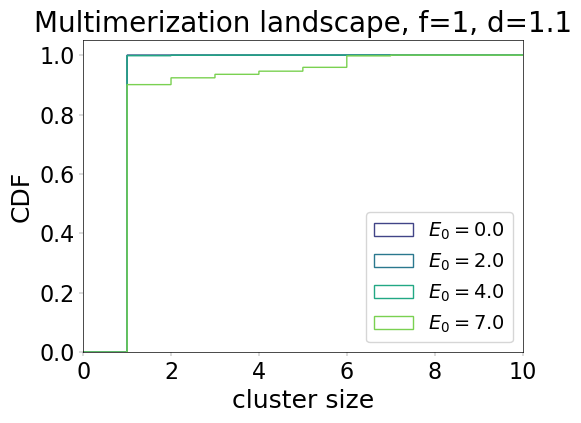

In [39]:
cluster_sizes = plot_multimerization(1, rep_r=1.1, cutoff=1.3, wrap=False)

E0 = 0.0


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(


99988
Fraction in monomers: 1.0
Fraction in dimers: 0.00012001440172820739
Fraction in multimers: 0.0
E0 = 7.0


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this 

99732
Fraction in monomers: 0.9944551397745959
Fraction in dimers: 0.004070910038904263
Fraction in multimers: 0.0014739501864998196
E0 = 15.0
99566
Fraction in monomers: 0.24422995801779723
Fraction in dimers: 0.08054958519976699
Fraction in multimers: 0.6752204567824358


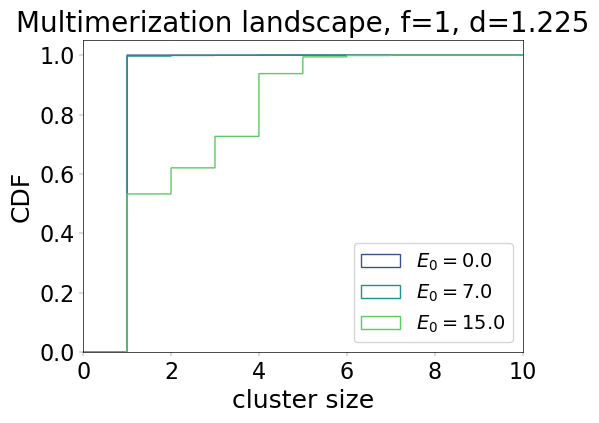

In [42]:
cluster_sizes = plot_multimerization(1, rep_r=1.175, cutoff=1.225, wrap=False)

In [ ]:
cluster_sizes, histogram = cluster_size_distribution_pruned(f, 15.0, N=1000, vol_fraction=0.3, 
                                                         r=0.5, rep_r=1.15, cutoff=1.3, wrap=False)

In [39]:
cluster_sizes, histogram = cluster_size_distribution_pruned(2, 25.0, N=1000, vol_fraction=0.3, 
                                                         r=0.35, rep_r=1.1, cutoff=1.3, wrap=False)

500


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this 

0.9999999999999999


Text(0.5, 1.0, 'f=2, $r_{rep}$=1.1, $r_{attr}$=0.35, $E_0$=25')

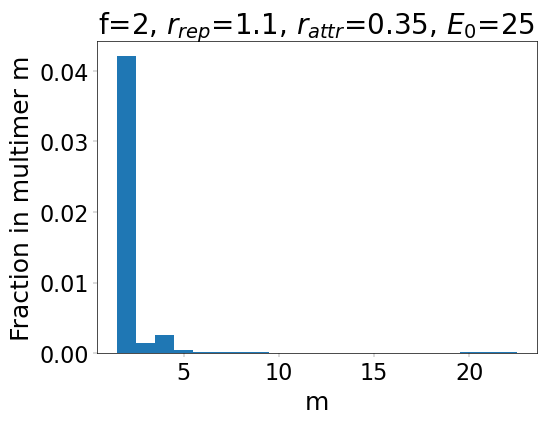

In [40]:
weights = histogram[histogram > 0] / histogram[histogram > 0].sum()
print(weights.sum())
cdf = np.cumsum(weights)
fig, ax = plt.subplots()
ax.bar(np.arange(2, len(weights) + 1), weights[1:], width=1.0)
ax.set_xlabel('m')
ax.set_ylabel('Fraction in multimer m')
ax.set_title('f=2, $r_{rep}$=1.1, $r_{attr}$=0.35, $E_0$=25')

In [13]:
cluster_sizes, histogram = cluster_size_distribution_pruned(DATADIR, 2, 25.0, N=1000, vol_fraction=0.45, 
                                                         r=0.35, rep_r=1.1, wrap=False)

/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this 

1.0


Text(0.5, 1.0, 'f=2, $r_{rep}$=1.1, $r_{attr}$=0.35, $E_0$=25, $v=0.45$')

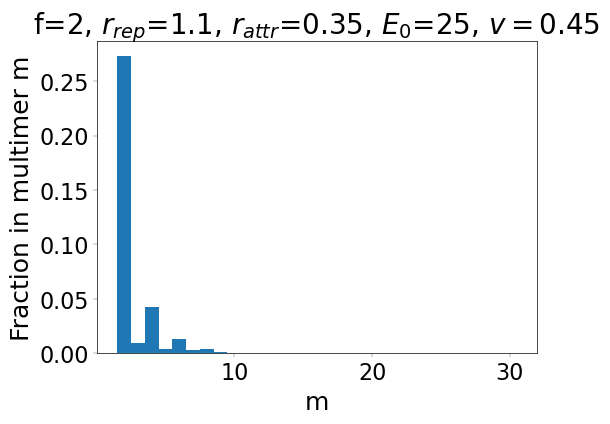

In [14]:
weights = histogram[histogram > 0] / histogram[histogram > 0].sum()
print(weights.sum())
cdf = np.cumsum(weights)
fig, ax = plt.subplots()
ax.bar(np.arange(2, len(weights) + 1), weights[1:], width=1.0)
ax.set_xlabel('m')
ax.set_ylabel('Fraction in multimer m')
ax.set_title('f=2, $r_{rep}$=1.1, $r_{attr}$=0.35, $E_0$=25, $v=0.45$')

In [37]:
cluster_sizes, histogram = cluster_size_distribution_pruned(1, 25.0, N=1000, vol_fraction=0.3, 
                                                         r=0.35, rep_r=1.05, cutoff=1.3, wrap=False)

500


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this 

1.0


Text(0.5, 1.0, 'f=1, $r_{rep}$=1.1, $r_{attr}$=0.35, $E_0$=25')

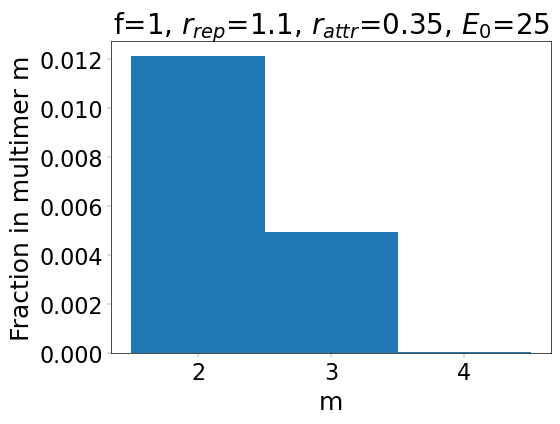

In [38]:
weights = histogram[histogram > 0] / histogram[histogram > 0].sum()
print(weights.sum())
cdf = np.cumsum(weights)
fig, ax = plt.subplots()
ax.bar(np.arange(2, len(weights) + 1), weights[1:], width=1.0)
ax.set_xlabel('m')
ax.set_ylabel('Fraction in multimer m')
ax.set_title('f=1, $r_{rep}$=1.1, $r_{attr}$=0.35, $E_0$=25')

In [41]:
weights = (histogram[histogram > 0] * np.array([1, 2, 3, 4])) / 1000
np.sum(weights)

0.9

E0 = 0.0


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this 

49996
Fraction in monomers: 0.9975398031842547
Fraction in dimers: 0.0022801824145931675
Fraction in multimers: 0.00018001440115209216
E0 = 11.0


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(


49970
Fraction in monomers: 0.9726836101660996
Fraction in dimers: 0.01304782869721833
Fraction in multimers: 0.014268561136682009
E0 = 20.0


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this 

49980
Fraction in monomers: 0.9113245298119248
Fraction in dimers: 0.07414965986394557
Fraction in multimers: 0.014525810324129652


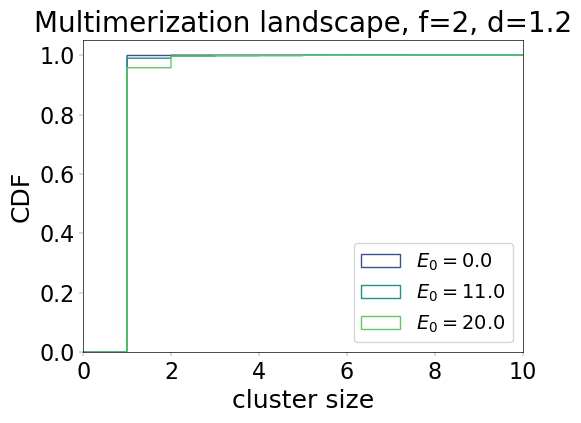

In [59]:
cluster_sizes = plot_multimerization(2, r=0.35, rep_r=1.1, cutoff=1.3, wrap=False)

In [56]:
Ds = []
for n in range(1, cluster_sizes.max()):
    Ds += [1./n] * np.sum(cluster_sizes == n) * n
len(Ds)

49940

In [58]:
1000 * 100

100000

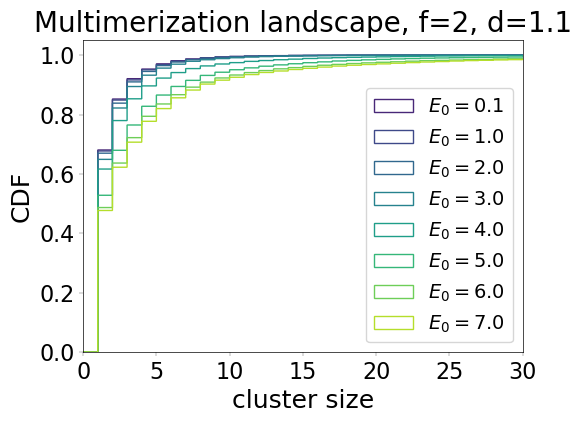

In [285]:
plot_multimerization(2, cutoff=1.1)

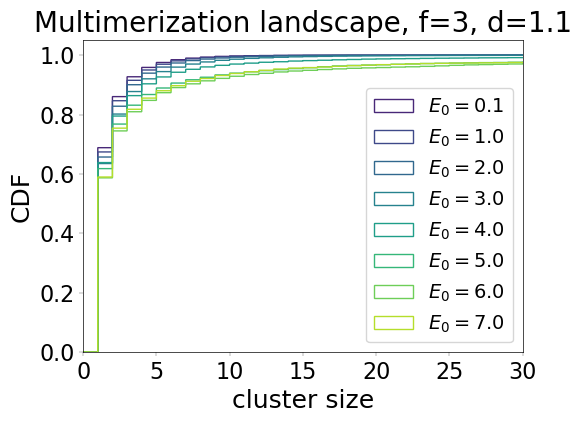

In [286]:
plot_multimerization(3, cutoff=1.1)

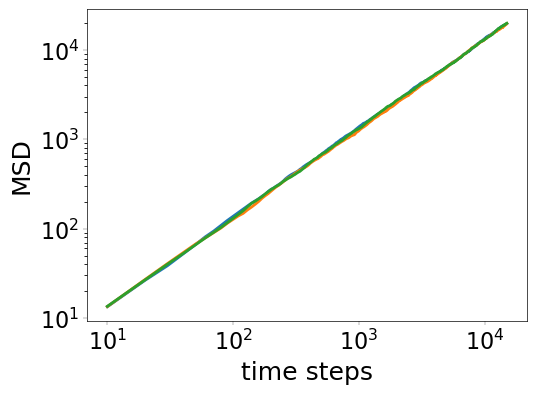

In [313]:
import pandas as pd

simdir = Path('/net/levsha/share/deepti/simulations/protein_mobility')
fig, ax = plt.subplots()
for E0 in [0.1, 6.0, 7.0]:
    path = simdir/f"N1000_f1_E0{E0}_v0.3_r0.25"
    msd_df = pd.read_csv(path/'sphere_msds_start5000_every_other_10.csv')
    ax.plot(msd_df['Time'].values[1:], msd_df['MSD'].values[1:], 
                        label=f"$E_0={E0}$")
ax.set_xlabel("time steps")
ax.set_ylabel("MSD")
ax.set_xscale("log")
ax.set_yscale("log")